In [2]:
import numpy as np
import seaborn as sns
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy.optimize import fsolve

import matplotlib 
matplotlib.rcParams['figure.figsize'] = (9.7082039325, 6.0)
matplotlib.rcParams['xtick.labelsize'] = 22.0
matplotlib.rcParams['ytick.labelsize'] = 22.0
matplotlib.rcParams['axes.labelsize'] = 22.0
matplotlib.rcParams['legend.fontsize'] = 20.0
matplotlib.rcParams['font.sans-serif']= ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex']= True 
matplotlib.rcParams['mathtext.fontset']= 'stixsans'

G = 6.67e-11
c = 2.998e8
Msun = 2e30
Rsun = 7e8
year = 3600.*24.*365
kpc = 1e3*3.086e16

Let's define the LISA PSD. I'll follow Eq. 1 of [Robson et al](https://arxiv.org/pdf/1803.01944.pdf)

/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


Text(0, 0.5, 'PSD')

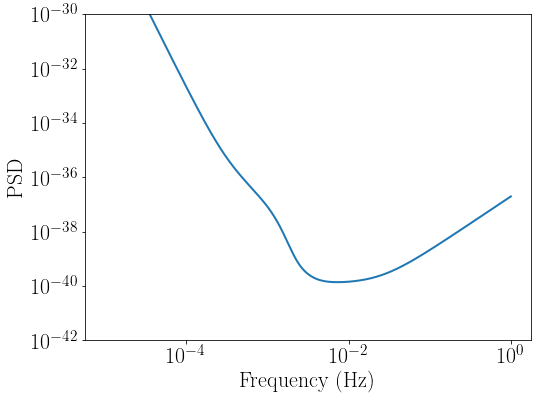

In [3]:
# https://arxiv.org/pdf/1803.01944.pdf

L_arm = 2.5e9
fref = 19.09e-3
def LISA_sensitivity(f):
    
    # Instrumental noise
    P_oms = np.power(1.5e-11,2.)*(1.+np.power(2.e-3/f,4.))
    P_acc = np.power(3.e-15,2.)*(1.+np.power(0.4e-3/f,2.))*(1.+np.power(f/8e-3,4))
    #P_n = P_oms/L_arm**2. + 2.*(1.+np.cos(f/fref)**2.)*P_acc/(np.power(2.*np.pi*f,4.)*L_arm**2.)    
    S_n = (10./(3.*L_arm*L_arm))*(P_oms + 4.*P_acc/np.power(2.*np.pi*f,4.))*(1.+(3./5.)*np.power(f/fref,2.))
    
    # Confusion noise (assume four years)
    A = 9e-45
    alpha = 0.138
    beta = -221.
    k = 521.
    gamma = 1680.
    fk = 1.13e-3
    S_conf = A*np.power(f,-7./3.)*np.exp(-f**alpha+beta*f*np.sin(k*f))*(1.+np.tanh(gamma*(fk-f)))
    
    # Impose upper frequency limit
    S_n[f>=1.] = np.inf
    S_conf[f>=1.] = np.inf
    
    return S_n + S_conf

f = np.logspace(-5,2,1000)
strain_sensitivity = LISA_sensitivity(f)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(f,strain_sensitivity,lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-42,1e-30)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD')

### LISA Signal-To-Noise

Averaging over sky position and binary inclination angles, the mean squared-SNR of a binary signal is

\begin{equation}
\langle \mathrm{SNR}\rangle^2 = \frac{16}{5} \int_0^\infty \frac{A^2(f)}{S_n(f)} df,
\end{equation}

where $A(f)$ is the amplitude of the strain signal and $S_n(f)$ is our total strain sensitivity given above. Caution -- $S_n(f)$ is *not* the effective PSD, but the PSD divided by the LISA transfer function.

Consider a toy binary with chirp mass $\mathcal{M}_c$ at distance $D$. Neglecting evolution, the gravitational-wave signal will have form

\begin{equation}
h(t) = \frac{4}{D} \left(\frac{G \mathcal{M}_c}{c^2} \right)^{5/3} \left(\frac{2\pi f_\mathrm{orb}}{c}\right)^{2/3} \cos(2\pi f_\mathrm{orb} t)
\end{equation}

Using Kepler's third law, this becomes

\begin{equation}
h(t) = \frac{4}{D} \frac{\eta}{a} \left(\frac{G M}{c^2}\right)^2 \cos(2\pi f_\mathrm{orb} t),
\end{equation}

where $a$ is the binary's semimajor axis and $M$ its total mass.
In the Fourier domain, we have

\begin{equation}
\boxed{A(f) = \frac{4}{D} \frac{\eta}{a} \left(\frac{G M}{c^2}\right)^2 \delta(f-2 f_\mathrm{orb})}
\end{equation}

Strictly speaking, this isn't a true delta function, but a "finite-time" delta function that evaluates to $\delta(0) = T$, the total observation time ($1/T$ is our maximum frequency resolution).
When substituting $A(f)$ into our SNR equation above, we'll let one of our two delta functions act as a finite time $delta$, giving

\begin{equation}
\begin{aligned}
\langle \mathrm{SNR}\rangle^2 &= \frac{16}{5} \left[\frac{4}{D} \frac{\eta}{a} \left(\frac{G M}{c^2}\right)^2\right]^2
        \int_0^\infty \frac{\delta^2(f-2f_\mathrm{orb})}{S_n(f)} df \\
    &= \frac{256}{5} \left(\frac{\eta}{a D}\right)^2 \left(\frac{G M}{c^2}\right)^4 T
        \int_0^\infty \frac{\delta(f-2f_\mathrm{orb})}{S_n(f)} df \\
    &= \frac{256}{5} \left(\frac{\eta}{a D}\right)^2 \left(\frac{G M}{c^2}\right)^4 \frac{T}{S_n(2f_\mathrm{orb})}
\end{aligned}
\end{equation}

In [4]:
def compute_Mc(m1,m2):
    
    """
    Returns chirp mass, given binary component masses
    """
    
    Mtot = m1+m2
    eta = (m1*m2)/np.power(m1+m2,2.)
    return np.power(eta,3./5.)*Mtot

def fdotGW_from_fGW_Mc(f_gw,Mc):
    
    """
    Returns df/dt assuming *purely gravitational-wave-driven evolution*, given a present GW frequency
    (i.e. twice the present orbital frequency) and a binary chirp mass.
    See Eq. 4.20 of Maggiore
    """
    
    return (96./5.)*np.power(np.pi,8./3.)*np.power(G*Mc*Msun/c**3.,5./3.)*f_gw**(11./3.)

def amp_from_fGW_mass_dist(f_gw,Mc,D):
    
    """
    Gravitational wave amplitude given a present GW frequency, binary chirp mass, and source distance.
    See Eq. 4.3 of Maggiore
    """
    
    return (4./(D*kpc))*np.power(G*Mc*Msun/c**2.,5./3.)*np.power(np.pi*f_gw/c,2./3.)

def a_from_fGW_mass(f_gw,m1,m2):
    
    """
    Binary separation, given current GW frequency and component masses.
    This is just Kepler's Law...
    """
    
    return np.power(G*(m1+m2)*Msun/(np.pi*f_gw)**2,1./3.)

def fGW_from_a_mass(a,m1,m2):
    
    return G*(m1+m2)*Msun/(np.pi*(a*Rsun)**3.)

In [5]:
def snr_from_a_adot(a0,adot,m1=1.,m2=1.,D=3.):
    
    # Final separation after mission lifetime
    a_final = max(0.0,a0+adot*5.)

    # GW frequencies
    f0 = fGW_from_a_mass(a0,m1,m2)
    if a_final==0:
        f_final = 10.
    else:
        f_final = fGW_from_a_mass(a_final,m1,m2)
    
    # Get fourier-domain amplitudes
    fourier_freqs = np.arange(f0,f_final,(f_final-f0)/300.)
    amp_at_f = amp_from_fGW_mass_dist(fourier_freqs,compute_Mc(m1,m2),D)
    
    sep_at_f = a_from_fGW_mass(fourier_freqs,m1,m2)
    fdot_at_f = -(3./(2.*np.pi))*np.sqrt(G*Msun)*np.power(sep_at_f,-5./2.)*(adot)
    
    hf = amp_at_f/np.sqrt(fdot_at_f)
    PSD = LISA_sensitivity(fourier_freqs)
    rho2 = (16./5.)*np.trapz(np.power(hf,2.)/PSD,fourier_freqs)
    
    return np.sqrt(rho2)/4

def snr_from_f_fdot(f0,fdot0,m1=1.,m2=1.,D=3.):
    
    if f0>=1.:
        return 0.
    f_final = min(1.,f0+fdot0*5.*year)
    fourier_freqs = np.arange(f0,f_final,(f_final-f0)/1000.)
    
    amp_at_f = amp_from_fGW_mass_dist(fourier_freqs,compute_Mc(m1,m2),D)
    sep_at_f = a_from_fGW_mass(fourier_freqs,m1,m2)

    adot = (-2.*np.pi/3.)*fdot0*np.power(sep_at_f,5./2.)/np.sqrt(G*(m1+m2)*Msun)
    fdot_at_f = fdot0
    hf = amp_at_f/np.sqrt(fdot_at_f)
    
    PSD = LISA_sensitivity(fourier_freqs)
    rho2 = (16./5.)*np.trapz(np.power(hf,2.)/PSD,fourier_freqs)

    return np.sqrt(rho2)/4

/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


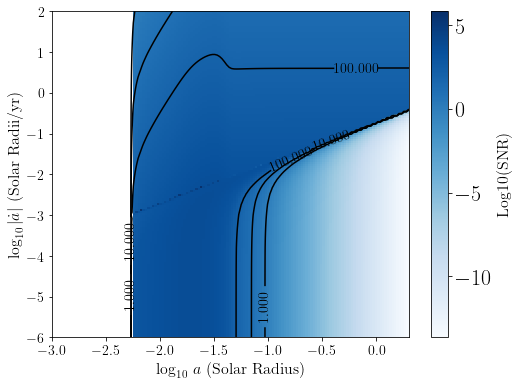

In [6]:
a_orbs = np.linspace(-3.,0.3,150)
adot_orbs = np.linspace(-6,2,160)
rhos = np.zeros((a_orbs.size,adot_orbs.size))
for i in tqdm(range(a_orbs.size)):
    for j in range(adot_orbs.size):
        rhos[i,j] = snr_from_a_adot(10.**a_orbs[i],-10.**adot_orbs[j],m1=0.5,m2=0.8,D=3.)

fig,ax = plt.subplots(figsize=(8,6))
PS = ax.pcolormesh(a_orbs,adot_orbs,np.log10(rhos).T,cmap='Blues')
CS = ax.contour(a_orbs,adot_orbs,rhos.T,levels=[1,10,100],colors='black')
ax.clabel(CS, inline=1, fontsize=14)
ax.set_xlabel(r'$\log_{10} \,a$ (Solar Radius)',fontsize=16)
ax.set_ylabel(r'$\log_{10} |\dot a|$ (Solar Radii/yr)',fontsize=16)
ax.tick_params(labelsize=14)
cb = fig.colorbar(PS)
cb.set_label(label="Log10(SNR)",fontsize=16)
#plt.savefig('./SNRs.pdf')


In [6]:
s_mass=G*(1.98892*10**(30))/(c**3)
solar_mass_gr = 1.989e33
secs_in_pc = 102927133.01 #about 1e8 s per pc
from math import pi,sqrt

def mchirp(m1,m2): return ((mu(m1,m2))**(3./5))*((M(m1,m2))**(2./5))  # chirp mass


# Mass functions

def mu(m1,m2): return s_mass*(m1*m2)/(m1+m2) # reduced mass

def M(m1,m2):  return s_mass*(m1+m2) # total mass


def soundSpeed(Temp):
    """
    This is the sound speed, c_s, where c_s^2 = k_B*T/m_p
    Returns dimensionless quantity. To get physical units, multiply by c.
    """
    kbTemp_GR = 3.80526e-76*Temp # seconds, for 1K
    mProton = 4.14324e-63 #seconds
    ans = kbTemp_GR/mProton
    return sqrt(ans)

def fdot_gw_mod(m1,m2,fgw):
    const = 96./5*pi**(8./3)
    num = (mchirp(m1,m2))**(5./3)*fgw**(11./3)
    ans = num*const
    return ans

def fdot_drag(m1,m2,temperature, Const, fgw):
    rho_0=1e-6*(1e-3)/(0.01)**3 # cm -> m
    num = 2*rho_0*Const*3*(6.67428*(10**(-11)))**(5/3.)*((m1+m2)*2e30)**(2/3.)*fgw**(2./3)
    deno = (soundSpeed(temperature)*c)**2*2*pi**(1/3.)
    ans = num/deno
    return ans

gw_vec = []
drag_vec = []
xax = []
m1=1
m2=1
temperature = 1e5
Const=1

for qq in range (1,1000):
    qq=qq/1000
    xax.append(qq)
    gw_vec.append(fdot_gw_mod(m1,m2,qq))
    drag_vec.append(fdot_drag(m1,m2,temperature, Const, qq))

In [7]:
f_ref, fdot_gw, fdot_drag = np.loadtxt('../fdot_and_f_m1_0.5_m2_0.3.txt',unpack=True)

In [8]:
wd_fs = np.array([6.22,3.51,3.22,2.12,1.94,1.84,1.81,1.48,1.45,1.36,1.25,2.61,1.68,0.84,0.51,0.47])*1e-3
m1s = np.array([0.55,0.8,0.8,0.8,0.68,0.8,0.65,0.8,0.8,0.9,0.9,0.25,0.3,0.3,0.3,0.5])
m2s = np.array([0.27,0.18,0.16,0.1,0.13,0.09,0.05,0.07,0.06,0.04,0.06,0.5,0.75,0.75,0.75,0.8])

etas = m1s*m2s/(m1s+m2s)**2.
Mcs = np.power(etas,3./5.)*(m1s+m2s)

In [9]:
fddotmin=(2./(5.*year))/(5.*year)**2. ## minimum measurable fddot (above this value, we should be able to measure the breaking index)

The breaking index is defined as

$$n=\frac{f\ddot{f}}{\dot{f}^2}$$

This helps relate $f$ and $\dot{f}$ at the minimum detectable $\ddot{f}$ value

$$\dot{f}^2=\frac{3}{11}\ddot{f}_{min} f $$

/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


(-20.0, -5.0)

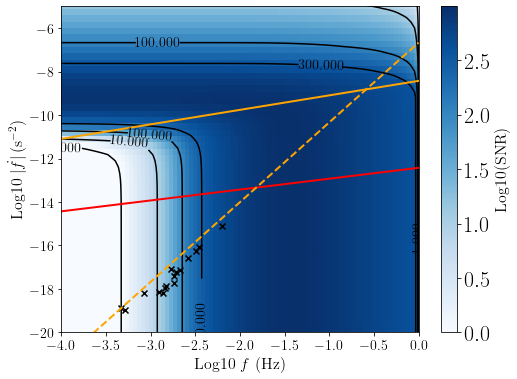

In [17]:
f_orbs = np.logspace(-4.,0,90)
fdot_orbs = np.logspace(-20,6,90)
rhos = np.zeros((f_orbs.size,fdot_orbs.size))
for i in range(f_orbs.size):
    for j in range(fdot_orbs.size):
        rhos[i,j] = snr_from_f_fdot(f_orbs[i],fdot_orbs[j])

fig,ax = plt.subplots(figsize=(8,6))

PS = ax.pcolormesh(np.log10(f_orbs),np.log10(fdot_orbs),np.log10(rhos).T,cmap='Blues',vmin=0)
CS = ax.contour(np.log10(f_orbs),np.log10(fdot_orbs),rhos.T,levels=[1,10,100,300],colors='black')

ax.clabel(CS, inline=1, fontsize=14)
ax.set_xlabel(r'Log10 $f$ (Hz)',fontsize=16)
ax.set_ylabel(r'Log10 $|\dot f|\,(\mathrm{s}^{-2})$',fontsize=16)
ax.scatter(np.log10(wd_fs),np.log10((96./5.)*np.power(np.pi,8./3.)*np.power(c,-5.)*np.power(G*Mcs*Msun,5./3.)*np.power(wd_fs,11./3.)),marker='x',color='black')
ax.plot(np.log10(f_ref),np.log10(fdot_drag),lw=2,color='orange')

fdot_at_fddotmin = np.sqrt(3./11*fddotmin*f_ref)
ax.plot(np.log10(f_ref),np.log10(fdot_at_fddotmin),lw=2,color='red')

xs = 10.**np.linspace(-4,0,100)
ys = fdotGW_from_fGW_Mc(xs,compute_Mc(0.5,0.8))
ax.plot(np.log10(xs),np.log10(ys),lw=2,color='orange',ls='--')

ax.tick_params(labelsize=14)
cb = fig.colorbar(PS)
cb.set_label(label="Log10(SNR)",fontsize=16)
ax.set_ylim(-20,-5)

In [10]:
def McfromFdot(f0,fdot):
    den=96./5*np.power(np.pi,8./3)*np.power(f0,11./3)
    
    return np.power(fdot/den,3./5)

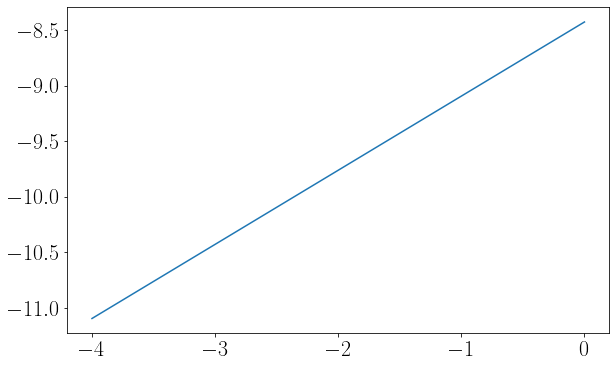

In [11]:
plt.plot(np.log10(f_ref),np.log10(fdot_drag))
plt.show()

In [12]:
def mchirp_q_to_m1_m2(mchirp,q):
    factor = mchirp*np.power(1+q, 1.0/5.0)
    m1 = factor*np.power(q, -3.0/5.0)
    m2 = factor*np.power(q, 2.0/5.0)
    return m1,m2

def func_opt(D,snr,Mc,f,fd):
    m1,m2=mchirp_q_to_m1_m2(Mc,1)
    
    return np.abs(snr-snr_from_f_fdot(f,fd,m1=m1,m2=m2,D=D))

def DfromSNRandMc(snr,Mc,f,fd):
    #InitialGuess = snr*Mc/3.#McfromFdot(f0,fdot)
    InitialGuess = 3.*Mc/compute_Mc(0.5,0.3)
    Mcsol = fsolve(func_opt,InitialGuess,args=(snr,Mc,f,fd))[0]## we need to do this numerically
    
    return Mcsol

In [13]:
SNR_d=[]
Mc_d=[]
D_d=[]
for f, fd in tqdm(zip(f_ref,fdot_drag)):
    snr=snr_from_f_fdot(f,fd,m1=0.5,m2=0.3,D=3.)
    Mc=McfromFdot(f,fd)/s_mass
    SNR_d.append(snr)
    Mc_d.append(Mc)
    D_d.append(DfromSNRandMc(snr,Mc,f,fd)) 

KeyboardInterrupt: 

In [ ]:
SNR_m=[]
Mc_m=[]
D_m=[]
for f, fd in tqdm(zip(f_ref,fdot_at_fddotmin)):
    snr=snr_from_f_fdot(f,fd,m1=0.5,m2=0.3,D=3.)
    Mc=McfromFdot(f,fd)/s_mass
    SNR_m.append(snr)
    Mc_m.append(Mc)
    D_m.append(DfromSNRandMc(snr,Mc,f,fd)) 

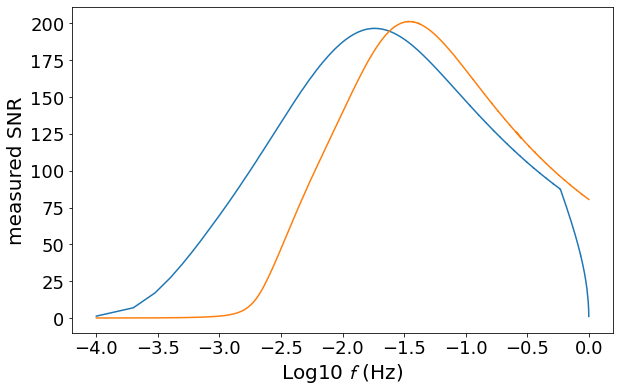

In [20]:
plt.plot(np.log10(f_ref),SNR_d)
plt.plot(np.log10(f_ref),SNR_m)
plt.xlabel(r'Log10 $f$ (Hz)')
plt.ylabel(r'measured SNR')
plt.show()

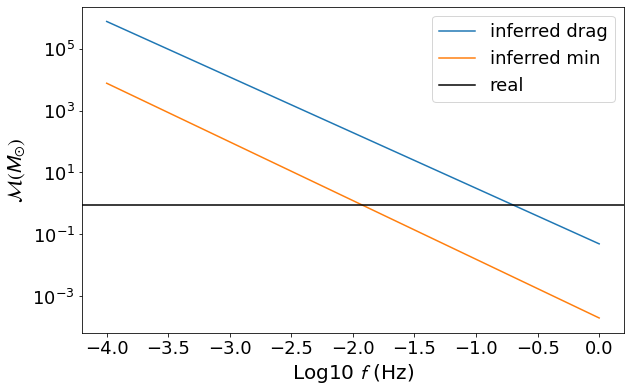

In [21]:
plt.plot(np.log10(f_ref),Mc_d,label='inferred drag')
plt.plot(np.log10(f_ref),Mc_m,label='inferred min')
plt.axhline(compute_Mc(1,1),c='k',label='real')
plt.legend()
plt.yscale('log')
plt.xlabel(r'Log10 $f$ (Hz)')
plt.ylabel(r'${\cal{M}} (M_{\odot})$')
plt.show()

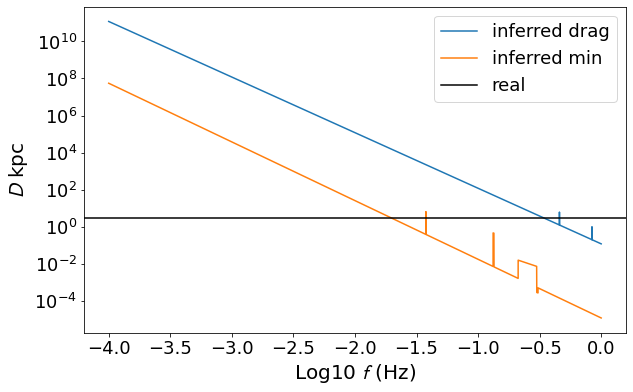

In [22]:
plt.plot(np.log10(f_ref),np.abs(D_d),label='inferred drag')
plt.plot(np.log10(f_ref),np.abs(D_m),label='inferred min')
plt.axhline(3,c='k',label='real')
plt.legend()
plt.yscale('log')
plt.xlabel(r'Log10 $f$ (Hz)')
plt.ylabel(r'$D$ kpc')
plt.show()

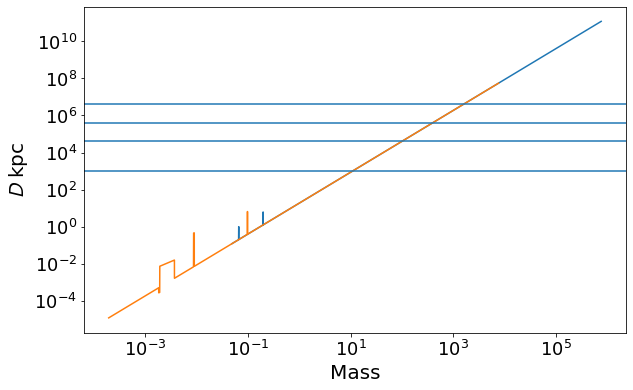

In [23]:
plt.plot(Mc_d,np.abs(D_d))
plt.plot(Mc_m,np.abs(D_m))
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Mass')
plt.ylabel(r'$D$ kpc')
plt.axhline(1000)
plt.axhline(40000)
plt.axhline(400000)
plt.axhline(4000000)
plt.show()

In [13]:
fs = np.logspace(-4,0,100)
fdots = np.logspace(-20,-12,100)
F,FD = np.meshgrid(fs,fdots)
fddots = (11./3.)*FD**2./F

fddots[fddots<fddotmin] = fddotmin
Ns = F*fddots/FD**2.

In [14]:
SNR_m=np.zeros((fs.size,fdots.size))
Mc_m=np.zeros((fs.size,fdots.size))
D_m=np.zeros((fs.size,fdots.size))

for i in tqdm(range(fs.size)):
    for j in range(fdots.size):
        SNR_m[i,j] = snr_from_f_fdot(fs[i],fdots[j],m1=0.5,m2=0.3,D=3.)
        Mc_m[i,j] = McfromFdot(fs[i],fdots[j])/s_mass
        D_m[i,j] = DfromSNRandMc(SNR_m[i,j],Mc_m[i,j],fs[i],fdots[j])

/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


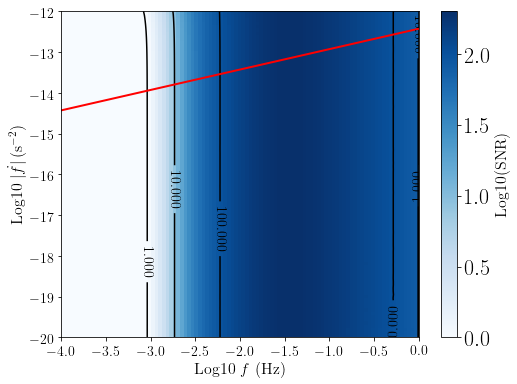

In [67]:
fig,ax = plt.subplots(figsize=(8,6))

PS = ax.pcolormesh(np.log10(fs),np.log10(fdots),np.log10(SNR_m).T,cmap='Blues',vmin=0)
CS = ax.contour(np.log10(fs),np.log10(fdots),SNR_m.T,levels=[1,10,100,300],colors='black')
cb = fig.colorbar(PS)
cb.set_label(label="Log10(SNR)",fontsize=16)
ax.clabel(CS, inline=1, fontsize=14)

ax.plot(np.log10(f_ref),np.log10(fdot_at_fddotmin),lw=2,color='red')
ax.set_xlim(-4,0)
ax.set_ylim(-20,-12)
ax.set_xlabel(r'log10 $f$ (Hz)',fontsize=16)
ax.set_ylabel(r'log10 $|\dot f|\,(\mathrm{s}^{-2})$',fontsize=16)
ax.tick_params(labelsize=14)

plt.show()

In [17]:
xs = 10.**np.linspace(-4,0,100)
fdot_min = 1./(5.*year)**2.
fddot_min = (2./(5.*year))/(5.*year)**2.
fdot_at_minimum_fddot = np.sqrt((3./11.)*xs*fddot_min)
fdot_at_fddotmin = np.sqrt(3./11*fddotmin*f_ref)

/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'label'
  after removing the cwd from sys.path.


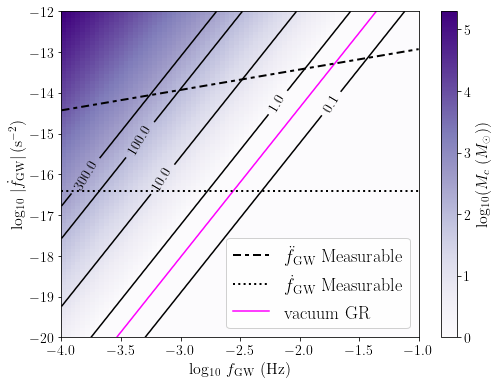

In [40]:
fig,ax = plt.subplots(figsize=(8,6))

PS = ax.pcolormesh(np.log10(fs),np.log10(fdots),np.log10(Mc_m).T,cmap='Purples',vmin=0,rasterized=True)
CS = ax.contour(np.log10(fs),np.log10(fdots),Mc_m.T,levels=[compute_Mc(0.5,0.3)],colors='magenta',label='vacuum GR')
CS = ax.contour(np.log10(fs),np.log10(fdots),Mc_m.T,levels=[0.1,1,10,100,300],colors='black')
cb = fig.colorbar(PS)
cb.set_label(label="log$_{10}$($M_c$ ($M_{\odot}))$",fontsize=16)
cb.ax.tick_params(labelsize=14)
ax.clabel(CS, inline=1, fontsize=14,fmt='%1.1f')

ax.plot(np.log10(f_ref),np.log10(fdot_at_fddotmin),lw=2,color='black',dashes=(4,2,2,2),label="$\ddot f_\mathrm{GW}$ Measurable")
ax.axhline(y=np.log10(fdot_min),color='black',ls=':',lw=2,label="$\dot f_\mathrm{GW}$ Measurable")
ax.set_xlim(-4,-1)
ax.set_ylim(-20,-12)
ax.set_xlabel(r'log$_{10}$ $f_{\mathrm{GW}}$ (Hz)',fontsize=16)
ax.set_ylabel(r'log$_{10}$ $|\dot f_{\mathrm{GW}}|\,(\mathrm{s}^{-2})$',fontsize=16)
ax.tick_params(labelsize=14)
ax.plot(1,2,color='magenta',label='vacuum GR')
ax.legend(ncol=1,loc='lower right',fontsize=18,fancybox=True,framealpha=0.9)

plt.show()
fig.savefig("McBias.pdf",bbox_inches='tight')

/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kchatziioannou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


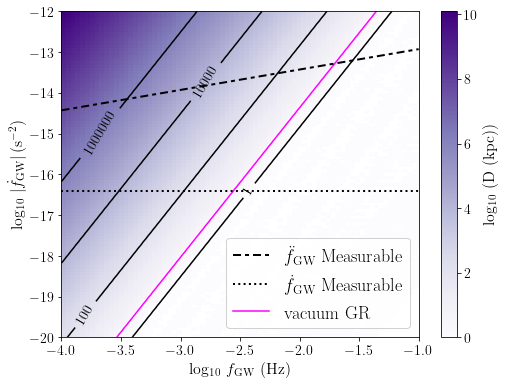

In [41]:
fig,ax = plt.subplots(figsize=(8,6))

PS = ax.pcolormesh(np.log10(fs),np.log10(fdots),np.log10(D_m).T,cmap='Purples',vmin=0,rasterized=True)
CS = ax.contour(np.log10(fs),np.log10(fdots),D_m.T,levels=[3],colors='magenta')
CS = ax.contour(np.log10(fs),np.log10(fdots),D_m.T,levels=[1,100,10000,1000000],colors='black')
cb = fig.colorbar(PS)
cb.set_label(label="log$_{10}$ (D (kpc))",fontsize=16)
cb.ax.tick_params(labelsize=14)
ax.clabel(CS, inline=1, fontsize=14,fmt='%1.0f')

ax.plot(np.log10(f_ref),np.log10(fdot_at_fddotmin),lw=2,color='black',dashes=(4,2,2,2),label="$\ddot f_\mathrm{GW}$ Measurable")
ax.axhline(y=np.log10(fdot_min),color='black',ls=':',lw=2,label="$\dot f_\mathrm{GW}$ Measurable")
ax.set_xlim(-4,-1)
ax.set_ylim(-20,-12)
ax.set_xlabel(r'log$_{10}$ $f_{\mathrm{GW}}$ (Hz)',fontsize=16)
ax.set_ylabel(r'log$_{10}$ $|\dot f_{\mathrm{GW}}|\,(\mathrm{s}^{-2})$',fontsize=16)
ax.tick_params(labelsize=14)
ax.plot(1,2,color='magenta',label='vacuum GR')
ax.legend(ncol=1,loc='lower right',fontsize=18,fancybox=True,framealpha=0.9)

plt.show()
fig.savefig("DLBias.pdf",bbox_inches='tight')

In [37]:
D_m

array([[ 1.48803106e+02,  1.79233868e+02,  2.15887829e+02, ...,
         1.02564209e+10,  1.23538953e+10,  1.48803106e+10],
       [ 1.05794685e+02,  1.27430072e+02,  1.53489973e+02, ...,
         7.29201724e+09,  8.78326058e+09,  1.05794685e+10],
       [ 7.52169467e+01,  9.05990786e+01,  1.09126911e+02, ...,
         5.18441238e+09,  6.24464306e+09,  7.52169467e+09],
       ...,
       [-1.32634567e-07, -1.48901124e-07, -1.68602485e-07, ...,
         4.37144949e-05,  5.26542639e-05,  6.34222472e-05],
       [-1.04793003e-07, -1.17645017e-07, -1.33210829e-07, ...,
         3.10797357e-05,  3.74356516e-05,  4.50913749e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])